Part 1 ‑ Exploratory data analysis

In [14]:
import pandas as pd
from pandas.io.json import json_normalize
import json

import datetime 
import matplotlib
import matplotlib.pyplot as plt


In [15]:
data = pd.read_json('logins.json') #load json as a string

In [16]:
data.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [17]:
data.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [18]:
data['counts'] = 0
data.set_index('login_time', inplace=True)  #set the dt column as the index 
#remember inplace=True puts it back in place
time_df = data.resample('15T').count()
time_df.head()

,counts
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


Text(0.5, 1.0, 'LogIns at 15 Minute Intervals')

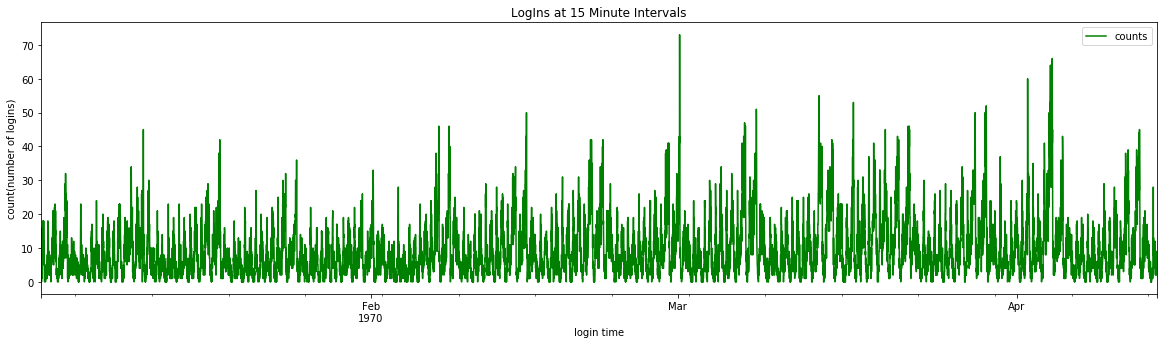

In [19]:
time_df.plot(figsize = (20,5), color='green')
plt.xlabel('login time')
plt.ylabel('count(number of logins)')
plt.title('LogIns at 15 Minute Intervals')

In [20]:
time_df.describe()

,counts
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


On average there are approximately 10 logins every 15 minutes.  The median shows 7 logins every 15 minutes.  There are a few outliers that are quite high around 70 logins.  There can be exploration on these exact dates to look for causes on these extremes.  Even those over 50 look to be more of outliers.  Looking at the quartiles or the visual plot, it is apparent the more normal amount of users falls well below those extremes.  

**Part 3 - Predictive Modeling**

In [21]:
import numpy as np
import pandas as pd

from pandas.io.json import json_normalize 
import json

from scipy import stats
from scipy.stats import norm
from scipy.stats import t
from numpy.random import seed

**1.  1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?**

In [58]:
with open('/Users/Sandi/Desktop/Projects/Mini_Projects/ultimate_challenge/ultimate_data_challenge.json') as f:
     #load data as JSON
    data = json.load(f)

#create df from JSON dataset
df = pd.DataFrame(data)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [ ]:
#handle categorical columns.  date strings into three separate or eliminate
#count each cities to see if important
#count each of the phones to see if important
#dummy variables--three columns for example, onehotencoding  #pandas

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [60]:
#handle the missing data

#impute the mean ratings for drivers
df['avg_rating_of_driver'].fillna(np.mean(df.avg_rating_of_driver), inplace=True)
df['avg_rating_by_driver'].fillna(np.mean(df.avg_rating_by_driver), inplace=True)

#label missing phone data as 'other'
df['phone'].fillna('other', inplace=True)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     50000 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [24]:
import datetime

In [25]:
#user retained if “active” (i.e. took a trip) in the preceding 30 days.
#parse dates
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)

In [26]:
df.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [27]:
df.last_trip_date.sort_values(ascending=False)[0]

Timestamp('2014-06-17 00:00:00')

In [28]:
#30 days before last trip
s = '2014-06-17'
d = datetime.datetime.strptime(s, '%Y-%m-%d') - datetime.timedelta(days=30)
print(d.strftime('%m/%d/%Y'))

05/18/2014


Any user taking a trip on or after May 18th, 2014 will be considered active.  Those whose trip was May 17th or before, are inactive.

In [29]:
#label target value column
df['active_or_not'] = (df.last_trip_date > '2014-05-17').astype(int)

In [38]:
df['active_or_not'].value_counts()

0    27255
1    22745
Name: active_or_not, dtype: int64

In [55]:
active = df['active_or_not'].loc[df['active_or_not'] == 1].value_counts()
active

1    22745
Name: active_or_not, dtype: int64

In [49]:
observed_users = df['active_or_not'].count()
observed_users

50000

In [56]:
#What fraction of the observed users were retained?
retained = active / observed_users
retained

1    0.4549
Name: active_or_not, dtype: float64

**1.**  The json file was converted to a dataframe.  The dates were then pared using datetime so to be readable as such.  The next task was to find the date of the last trip taken, followed by looking at what was 30 days prior to it.  This is where timedelta was used to discover the date of 05/18/2014.  Therefore, any user taking a trip on or after May 18th, 2014 will be considered active.  Those whose trip was May 17th or before, are inactive.

**There were 22,745 that were active out of the 50,000 observed users.  The fraction retained was 0.4549, approximately 46%.**  

**2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.**

**ultimate_black_user**: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
**avg_rating_of_driver**: the rider’s average rating of their drivers over all of their trips
**last_trip_date**: the last time this user completed a trip; in the form ‘YYYY MM DD’
**signup_date**: date of account registration; in the form ‘YYYY MM DD’


Logistic Regression
https://www.statisticssolutions.com/what-is-logistic-regression/
Logistic regression is the appropriate regression analysis to conduct when the dependent variable is dichotomous (binary). ... Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables.

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# Feature Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [ ]:
#create the values for whether or not a user will be active in their 6th month on the system

In [74]:
#fit model with all the features first.  Check importance, coefficients for elimination if not important


In [75]:
x = df
y = df['']

In [76]:
# Split the data into a training and test set.
xtrain, xtest, ytrain, ytest = train_test_split( 
        x, y, test_size = 0.25, random_state = 0) 


In [83]:
xtrain.shape

(37500, 2)

In [84]:
ytrain.shape

(37500, 12)

In [77]:
xtrain.size

75000

In [78]:
xtest.size

25000

In [79]:
ytrain.size

450000

In [80]:
ytest.size

150000

In [81]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression(max_iter=1000)

In [82]:
# fit the model with data
logreg.fit(xtrain,ytrain)

ValueError: bad input shape (37500, 12)

In [ ]:
#sklearn.preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)


https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
Standardize features by removing the mean and scaling to unit variance